# Membaca data

Melakukan load data dan melihat informasi dari data dan menampilkan 5 baris pertama dari data

In [1]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import itertools
import joblib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from dython.nominal import associations

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('loan_data_2007_2014.csv')
# melihat informasi dari data
df.info()                                 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [4]:
# menampilkan 5 baris pertama dari data
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analisis Data

Melihat status peminjaman

Current                                                48.09%
Fully Paid                                             39.62%
Charged Off                                             9.11%
Late (31-120 days)                                      1.48%
In Grace Period                                         0.67%
Does not meet the credit policy. Status:Fully Paid      0.43%
Late (16-30 days)                                       0.26%
Default                                                 0.18%
Does not meet the credit policy. Status:Charged Off     0.16%
Name: loan_status, dtype: object
<bound method DataFrame.count of         Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
0                0  1077501    1296599       5000         5000   
1                1  1077430    1314167       2500         2500   
2                2  1077175    1313524       2400         2400   
3                3  1076863    1277178      10000        10000   
4                4  1075358    1311748       3

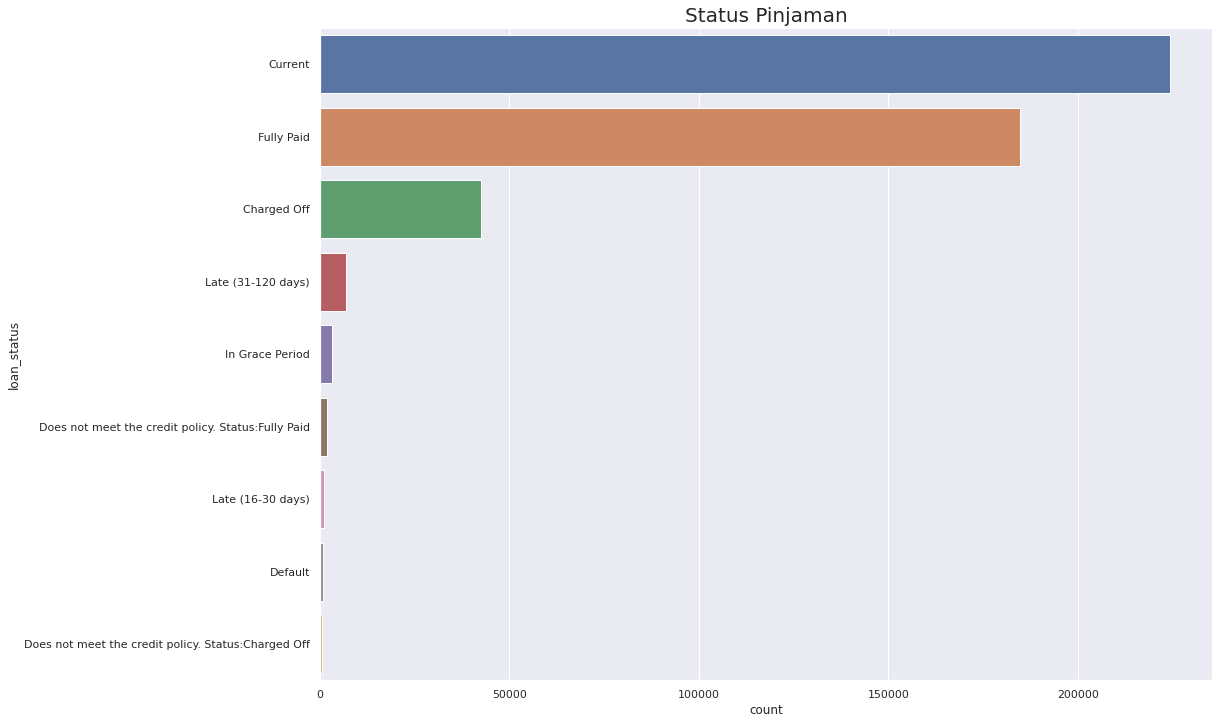

In [5]:
def plotcount(df, y, title, **sns_kwargs):
  data = df['loan_status'].value_counts()

  plt.figure(figsize=(16,12))
  plt.title(title, fontsize=20)
  sns.countplot(data = df, y = df['loan_status'], order=data.index, **sns_kwargs)

  percentage = data / data.sum()
  percentage = percentage.apply("{:.2%}".format)

  print(percentage)

plotcount(df, y = 'loan_status', title = "Status Pinjaman")
total_rows = df.count
print(total_rows)

Karena current dan in grace period merupakan status yang netral (Tidak termasuk gagal bayar atau berhasil bayar), maka data tersebut kita hapus saja.

Fully Paid                                             77.32%
Charged Off                                            17.78%
Late (31-120 days)                                      2.89%
Does not meet the credit policy. Status:Fully Paid      0.83%
Late (16-30 days)                                       0.51%
Default                                                 0.35%
Does not meet the credit policy. Status:Charged Off     0.32%
Name: loan_status, dtype: object
<bound method DataFrame.count of         Unnamed: 0       id  member_id  loan_amnt  funded_amnt  \
0                0  1077501    1296599       5000         5000   
1                1  1077430    1314167       2500         2500   
2                2  1077175    1313524       2400         2400   
3                3  1076863    1277178      10000        10000   
5                5  1075269    1311441       5000         5000   
...            ...      ...        ...        ...          ...   
466276      466276  9695736   11547808

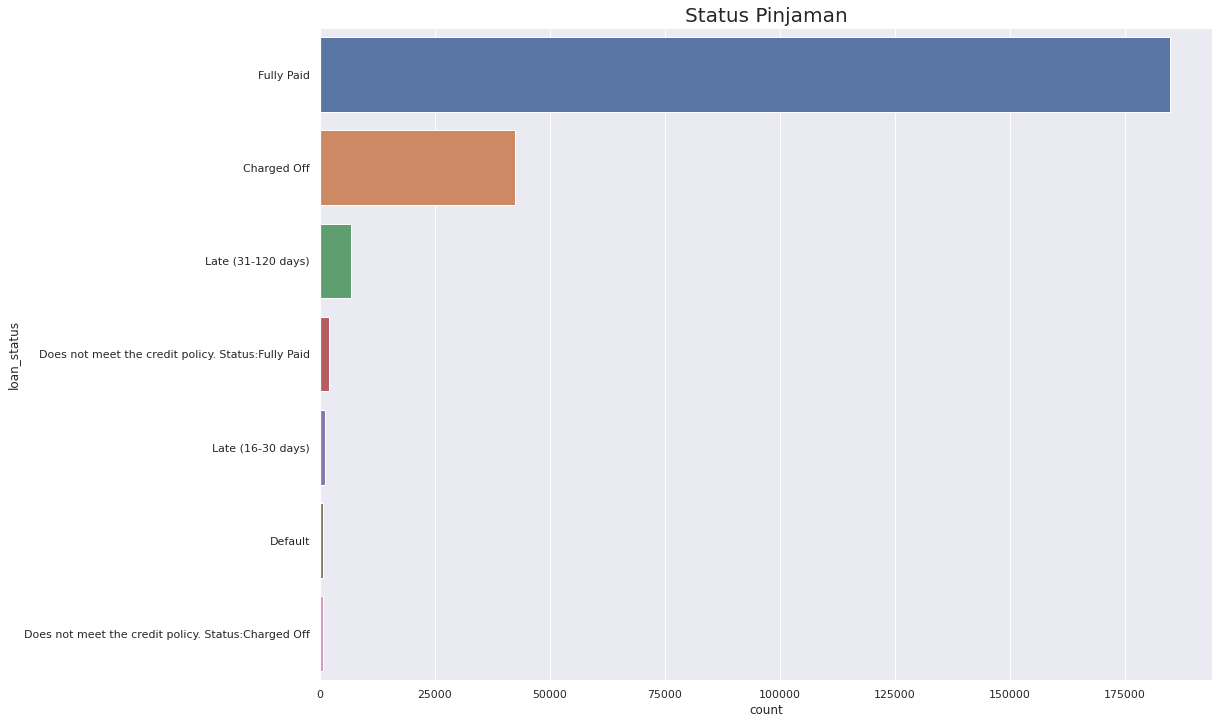

In [6]:
df.drop(df[(df['loan_status'] == "Current")].index, inplace=True)
df.drop(df[(df['loan_status'] == "In Grace Period")].index, inplace = True)
plotcount(df, y = 'loan_status', title = "Status Pinjaman")
total_rows = df.count
print(total_rows)

Credit risk yang seharusnya diterima pada waktu yang akan data adalah status peminjamannya "Fully Paid" atau berhasil dilunaskan, sementara yang ditolak adalah pinjaman dengan status charged off, default dan does not meet the credit policy.

In [7]:
approved =[
    "Fully Paid"
]
dissaproved = [
    "Charged Off",
    "Does not meet the credit policy. Status:Fully Paid",
    "Default",
    "Does not meet the credit policy. Status:Charged Off"
]

Kita lakukan standarisasi, dimana jika pinjaman diterima karena statusnya adalah fully paid akan bernilai 1, selain itu bernilai 0

In [8]:
def label_loan_status(value):
    if value in approved:
        return 1
    return 0

label_loan_status("Fully Paid")

1

1    80.04%
0    19.96%
Name: loan_status, dtype: object


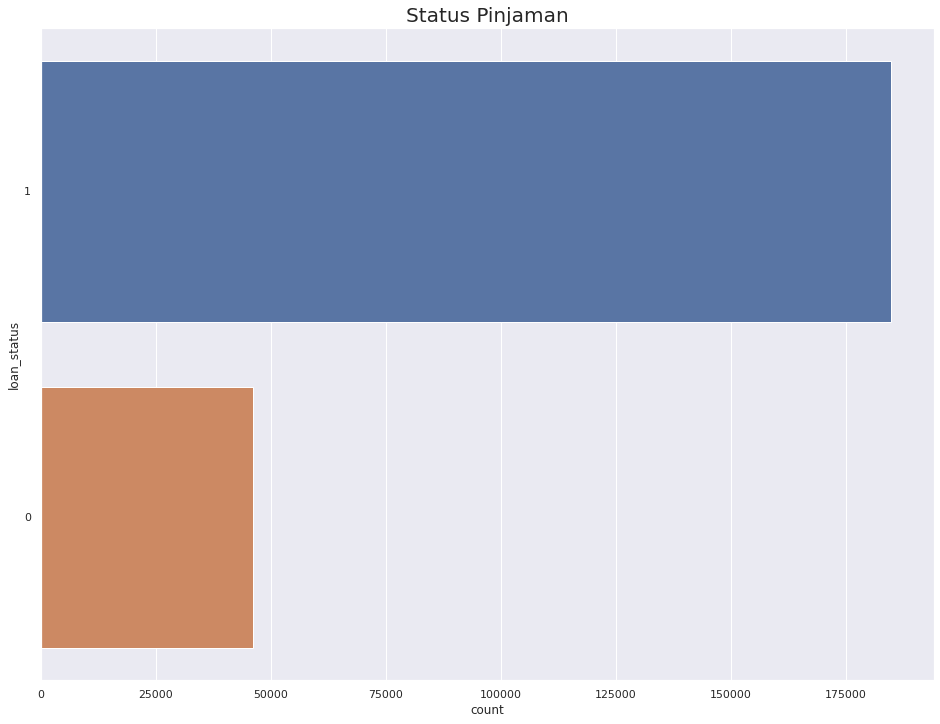

In [9]:
new_df = df[df["loan_status"].isin(approved + dissaproved)].copy()
new_df["loan_status"] = new_df["loan_status"].apply(label_loan_status)
plotcount(new_df, y="loan_status", title="Status Pinjaman")

Dari grafik diatas, dapat dilihat bahwa distribusi data tidak seimbang, sehingga perlu dilakukan data sampling sebelum melakukan pelatihan model machine learning

Selanjutnya kita akan menghapus kolom yang menurut penulis memeliki pengaruh kecil atau tidak berpengaruh dalam penentu keputusan apakah status pinjaman tersebut berhasil dibayar lunas atau tidak.

In [10]:
# Informasi rinci mengenai kolom dan baris data
data_stat = pd.DataFrame()
data_stat.index = new_df.columns
data_stat["unique_value"] = new_df.nunique()
data_stat["missing_rate"] = new_df.isna().mean()
data_stat["dtype"] = new_df.dtypes
data_stat


,unique_value,missing_rate,dtype
Unnamed: 0,230795,0.000000,int64
id,230795,0.000000,int64
member_id,230795,0.000000,int64
loan_amnt,1308,0.000000,int64
funded_amnt,1311,0.000000,int64
...,...,...,...
all_util,0,1.000000,float64
total_rev_hi_lim,9021,0.288026,float64
inq_fi,0,1.000000,float64
total_cu_tl,0,1.000000,float64


In [11]:
# Kolom yang tidak terdapat nilai
miss_col = data_stat[data_stat["missing_rate"] == 1].index.to_list()
print("Kolom yang tidak memiliki nilai:")
print(miss_col)
print()

# Kolom yang terlalu unik
vari_col = data_stat[data_stat["unique_value"] == new_df.shape[0]].index.to_list()
print("Kolom yang terlalu unik:")
print(vari_col)
print()

# Kolom dengan kategori yang banyak
cat_col_stat = data_stat[data_stat["dtype"] == "object"]
vari_cat_col = cat_col_stat[cat_col_stat["unique_value"] > 1000].index.to_list()
print("Kolom dengan kategori yang banyak:")
print(vari_cat_col)
print()

# Kolom yang terdiri dari satu nilai
single_valued_col = data_stat[data_stat["unique_value"] == 1].index.to_list()
print("Kolom yang terlalu unik:")
print(single_valued_col)
print()

removed_features = miss_col + vari_col + vari_cat_col + single_valued_col

Kolom yang tidak memiliki nilai:
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

Kolom yang terlalu unik:
['Unnamed: 0', 'id', 'member_id', 'url']

Kolom dengan kategori yang banyak:
['emp_title', 'url', 'desc', 'title']

Kolom yang terlalu unik:
['policy_code', 'application_type']



Menghitung korelasi kolom loan_status dengan kolom lainnya untuk mengetahui parameter yang mempengaruhi nilai pada loan_status

In [12]:
# Hilangkan fitur yang tidak terpakai
pre_df = new_df.loc[:, ~new_df.columns.isin(removed_features)].copy()
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230795 entries, 0 to 466283
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    230795 non-null  int64  
 1   funded_amnt                  230795 non-null  int64  
 2   funded_amnt_inv              230795 non-null  float64
 3   term                         230795 non-null  object 
 4   int_rate                     230795 non-null  float64
 5   installment                  230795 non-null  float64
 6   grade                        230795 non-null  object 
 7   sub_grade                    230795 non-null  object 
 8   emp_length                   222040 non-null  object 
 9   home_ownership               230795 non-null  object 
 10  annual_inc                   230791 non-null  float64
 11  verification_status          230795 non-null  object 
 12  issue_d                      230795 non-null  object 
 13 

Mencari fitur numerik yang akan digunakan

In [13]:
correlations = (pre_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=0)
                         .dropna(how="all", axis=1)
)

data = correlations["loan_status"].abs().sort_values(ascending=False)
data


loan_status                    1.000000
total_rec_prncp                0.460338
recoveries                     0.445422
last_pymnt_amnt                0.384781
total_pymnt_inv                0.358588
total_pymnt                    0.355349
collection_recovery_fee        0.300094
int_rate                       0.241059
total_rec_late_fee             0.152231
inq_last_6mths                 0.116393
dti                            0.107257
out_prncp                      0.099816
out_prncp_inv                  0.099814
revol_util                     0.089180
tot_cur_bal                    0.076230
mths_since_last_record         0.062190
annual_inc                     0.061623
total_rev_hi_lim               0.052931
loan_amnt                      0.049253
funded_amnt                    0.048790
funded_amnt_inv                0.039854
installment                    0.033419
total_rec_int                  0.032997
total_acc                      0.030680
mths_since_last_delinq         0.029299


Kita masukkan kolom dengan nilai korelasi lebih dari 0.1 ke dalam dataframe yang akan digunakan untuk pelatihan machine learning

In [14]:
a = 0
num_app = []
for i in data.values:
  if i > 0.1 :
    num_app.append(data.index[a])
  a += 1

num_app

['loan_status',
 'total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'total_pymnt_inv',
 'total_pymnt',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'inq_last_6mths',
 'dti']

In [15]:
# kolom-kolom yang berdata tanggal
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

for col in date_cols:
    print(pre_df[col].value_counts().iloc[:5])
    print()

14-Oct    8808
14-Jul    8614
14-Apr    6744
13-Nov    6665
13-Oct    6653
Name: issue_d, dtype: int64

Oct-00    1972
Oct-99    1837
Nov-00    1796
1-Oct     1779
Aug-00    1758
Name: earliest_cr_line, dtype: int64

15-Jul    11703
15-Mar    10087
15-Jun    10078
15-Apr    10051
15-Aug     9932
Name: last_pymnt_d, dtype: int64

16-Jan    93758
15-Dec    13753
15-Nov     8199
15-Sep     7942
15-Oct     7805
Name: last_credit_pull_d, dtype: int64

16-Feb    795
11-Mar    107
11-Apr    101
11-Feb     91
11-Jan     79
Name: next_pymnt_d, dtype: int64



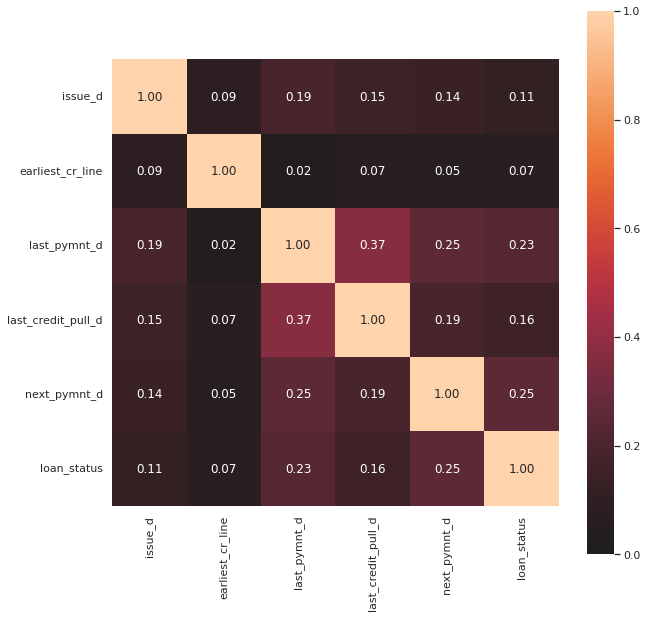

In [16]:
# Korelasi antar tanggal dan status pinjaman
used_cols = date_cols + ["loan_status"] 
complete_correlation = associations(
    pre_df[used_cols], 
    filename='date_correlation.png',
    figsize=(10,10)
)

In [17]:
date_cols_app = ["issue_d", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

In [18]:
# Kolom-kolom yang berdata kategorik
cat_features = pre_df.select_dtypes(include=object).columns
cat_features

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

In [19]:
other_cat_cols = cat_features[~cat_features.isin(date_cols)]
other_cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'initial_list_status'],
      dtype='object')

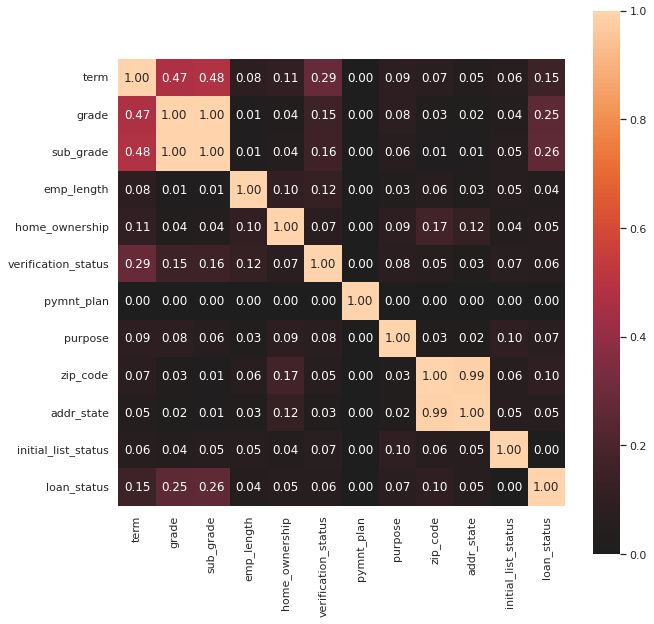

In [20]:
# Korelasi antar fitur kategorikal dan status pinjaman
used_cols = other_cat_cols.to_list() + ["loan_status"]
complete_correlation = associations(
    pre_df[used_cols], 
    filename='cat_correlation.png',
    figsize=(10,10)
)

In [21]:
#kolom_kategori yang akan dipakai
cat_app = ['term', 'grade', 'sub_grade']

In [22]:
app = num_app + date_cols_app + cat_app
app_df = pre_df[app]

Mencari kolom yang terdapat nilai null

In [23]:
app_df.isna().mean().sort_values(ascending=False)

next_pymnt_d               0.984484
last_pymnt_d               0.001629
inq_last_6mths             0.000126
last_credit_pull_d         0.000100
total_rec_prncp            0.000000
grade                      0.000000
term                       0.000000
issue_d                    0.000000
dti                        0.000000
loan_status                0.000000
total_rec_late_fee         0.000000
int_rate                   0.000000
collection_recovery_fee    0.000000
total_pymnt                0.000000
total_pymnt_inv            0.000000
last_pymnt_amnt            0.000000
recoveries                 0.000000
sub_grade                  0.000000
dtype: float64

memasukkan nilai pada kolom yang terdapat data null

In [24]:
# kita isi kolom next_pymnt_d, last_pymnt_d dan inq_lat_6mths dengan nilai lunas
# karena terdapat kemungkinan hutang sudah dibayar lunas

app_df["next_pymnt_d"] = app_df["next_pymnt_d"].fillna("lunas")
app_df["last_pymnt_d"] = app_df["last_pymnt_d"].fillna("lunas")
app_df["last_credit_pull_d"] = app_df["last_credit_pull_d"].fillna("lunas")

# kolom inq_last_6months akan diisi dengan nilai modus
mode = app_df["inq_last_6mths"].mode().values[0]
app_df["inq_last_6mths"] = app_df["inq_last_6mths"].fillna(mode)

# cek apakah masih ada kolom yang terdapat nilai null
app_df.isna().mean().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

loan_status                0.0
total_rec_prncp            0.0
grade                      0.0
term                       0.0
next_pymnt_d               0.0
last_credit_pull_d         0.0
last_pymnt_d               0.0
issue_d                    0.0
dti                        0.0
inq_last_6mths             0.0
total_rec_late_fee         0.0
int_rate                   0.0
collection_recovery_fee    0.0
total_pymnt                0.0
total_pymnt_inv            0.0
last_pymnt_amnt            0.0
recoveries                 0.0
sub_grade                  0.0
dtype: float64

# Melakukan pemodelan data

In [25]:
train_df = app_df


In [26]:
x = train_df.drop(columns = "loan_status")
y = app_df["loan_status"]

In [27]:
num_features = x.select_dtypes(exclude="object")
cat_features = x.select_dtypes(include="object")

In [28]:
# Normalisasi fitur numerik
num_features = (num_features - num_features.mean()) / num_features.std()
num_features

,total_rec_prncp,recoveries,last_pymnt_amnt,total_pymnt_inv,total_pymnt,collection_recovery_fee,int_rate,total_rec_late_fee,inq_last_6mths,dti
0,-0.765957,-0.222400,-0.822146,-0.800159,-0.812658,-0.149837,-0.716859,-0.139146,0.078612,1.472931
1,-1.320543,-0.071386,-0.829680,-1.310168,-1.326547,-0.140651,0.340654,-0.139146,3.480063,-2.000498
2,-1.083314,-0.222400,-0.752787,-1.099216,-1.115272,-0.149837,0.498595,-0.139146,0.928975,-0.994312
3,-0.155655,-0.222400,-0.795193,-0.123979,-0.138548,-0.149837,-0.066786,2.788316,0.078612,0.475868
5,-0.765957,-0.222400,-0.823681,-0.821350,-0.836983,-0.149837,-1.346331,-0.139146,1.779338,-0.671081
...,...,...,...,...,...,...,...,...,...,...
466276,-1.332307,1.273040,-0.815471,-1.202181,-1.218395,-0.053887,1.022774,-0.139146,-0.771750,-0.530319
466277,-0.817113,-0.222400,-0.765357,-0.822146,-0.836953,-0.149837,-1.346331,-0.139146,-0.771750,-0.784472
466278,-0.155655,-0.222400,-0.049229,-0.106227,-0.120771,-0.149837,1.022774,-0.139146,-0.771750,-0.622857
466281,-1.152029,-0.222400,-0.844495,-0.922172,-0.937959,-0.149837,1.416480,-0.139146,3.480063,0.273848


In [29]:
# OneHotEncode fitur kategorik
cat_features = pd.get_dummies(cat_features)
cat_features

,issue_d_10-Apr,issue_d_10-Aug,issue_d_10-Dec,issue_d_10-Feb,issue_d_10-Jan,issue_d_10-Jul,issue_d_10-Jun,issue_d_10-Mar,issue_d_10-May,issue_d_10-Nov,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Gabungkan Fitur
features_full = pd.concat([num_features, cat_features], axis=1)
x = features_full

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

Melakukan Over sampling menggunakan SMOTE

In [32]:
sm = SMOTE(random_state = 2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

In [33]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 147661
Before OverSampling, counts of label '0': 36975 

After OverSampling, counts of label '1': 147661
After OverSampling, counts of label '0': 147661


In [34]:
lr1 = LogisticRegression()
lr1.fit(x_train_res, y_train_res.ravel())
predictions = lr1.predict(x_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      9081
           1       0.99      0.99      0.99     37078

    accuracy                           0.99     46159
   macro avg       0.98      0.98      0.98     46159
weighted avg       0.99      0.99      0.99     46159



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [35]:
joblib.dump(lr1, "logres.z")
logres = joblib.load("logres.z")

In [36]:
logres.score(x_train, y_train)

0.9884421239628242

In [37]:
report = classification_report(y_true=y_train, y_pred=logres.predict(x_train))
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     36975
           1       0.99      0.99      0.99    147661

    accuracy                           0.99    184636
   macro avg       0.98      0.98      0.98    184636
weighted avg       0.99      0.99      0.99    184636



In [38]:
logres.score(x_test, y_test)

0.9868931302671202

In [39]:
report = classification_report(y_true=y_test, y_pred=logres.predict(x_test))
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      9081
           1       0.99      0.99      0.99     37078

    accuracy                           0.99     46159
   macro avg       0.98      0.98      0.98     46159
weighted avg       0.99      0.99      0.99     46159

